In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import decomposition
from sklearn import datasets

df = pd.read_csv('./data/SN7577.tab', sep='\t', lineterminator='\n')
X = df.drop('sex', axis=1).to_numpy()
y = df['sex'].to_numpy()
df
y

array([2, 1, 2, ..., 1, 1, 1], dtype=int64)

C:\Users\etpha\AppData\Local\Temp/ipykernel_11832/2455253673.py:15: RuntimeWarning: Mean of empty slice.
  X[y == label, 0].mean(),
C:\Users\etpha\miniconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\etpha\AppData\Local\Temp/ipykernel_11832/2455253673.py:16: RuntimeWarning: Mean of empty slice.
  X[y == label, 1].mean(),


ValueError: invalid entry in choice array

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


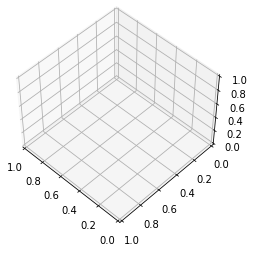

In [10]:
fig = plt.figure(1, figsize=(4, 3))
plt.clf()

ax = fig.add_subplot(111, projection="3d", elev=48, azim=134)
ax.set_position([0, 0, 0.95, 1])


plt.cla()
pca = decomposition.PCA(n_components=2)
pca.fit(X)
X = pca.transform(X)

for name, label in [(1, 0), (2, 1)]:
    ax.text3D(
        X[y == label, 0].mean(),
        X[y == label, 1].mean(),
        0,
        name,
        horizontalalignment="center",
        bbox=dict(alpha=0.5, edgecolor="w", facecolor="w"),
    )
# Reorder the labels to have colors matching the cluster results
y = np.choose(y, [1, 0]).astype(float)
ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.nipy_spectral, edgecolor="k")

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])

plt.show()

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

clf = DecisionTreeClassifier(max_leaf_nodes=3, random_state=0)
clf.fit(X_train, y_train)

n_nodes = clf.tree_.node_count
children_left = clf.tree_.children_left
children_right = clf.tree_.children_right
feature = clf.tree_.feature
threshold = clf.tree_.threshold

node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
while len(stack) > 0:
    # `pop` ensures each node is only visited once
    node_id, depth = stack.pop()
    node_depth[node_id] = depth

    # If the left and right child of a node is not the same we have a split
    # node
    is_split_node = children_left[node_id] != children_right[node_id]
    # If a split node, append left and right children and depth to `stack`
    # so we can loop through them
    if is_split_node:
        stack.append((children_left[node_id], depth + 1))
        stack.append((children_right[node_id], depth + 1))
    else:
        is_leaves[node_id] = True

print(
    "The binary tree structure has {n} nodes and has "
    "the following tree structure:\n".format(n=n_nodes)
)
for i in range(n_nodes):
    if is_leaves[i]:
        print(
            "{space}node={node} is a leaf node.".format(
                space=node_depth[i] * "\t", node=i
            )
        )
    else:
        print(
            "{space}node={node} is a split node: "
            "go to node {left} if X[:, {feature}] <= {threshold} "
            "else to node {right}.".format(
                space=node_depth[i] * "\t",
                node=i,
                left=children_left[i],
                feature=feature[i],
                threshold=threshold[i],
                right=children_right[i],
            )
        )

The binary tree structure has 5 nodes and has the following tree structure:

node=0 is a split node: go to node 1 if X[:, 1] <= 2.691735029220581 else to node 2.
	node=1 is a split node: go to node 3 if X[:, 0] <= -7.100281476974487 else to node 4.
	node=2 is a leaf node.
		node=3 is a leaf node.
		node=4 is a leaf node.


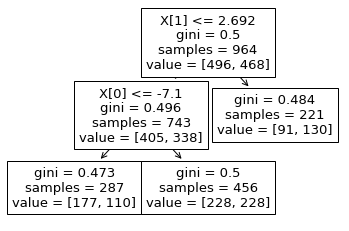

In [12]:
tree.plot_tree(clf)
plt.show()

In [13]:
node_indicator = clf.decision_path(X_test)
leaf_id = clf.apply(X_test)

sample_id = 0
# obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
node_index = node_indicator.indices[
    node_indicator.indptr[sample_id] : node_indicator.indptr[sample_id + 1]
]

print("Rules used to predict sample {id}:\n".format(id=sample_id))
for node_id in node_index:
    # continue to the next node if it is a leaf node
    if leaf_id[sample_id] == node_id:
        continue

    # check if value of the split feature for sample 0 is below threshold
    if X_test[sample_id, feature[node_id]] <= threshold[node_id]:
        threshold_sign = "<="
    else:
        threshold_sign = ">"

    print(
        "decision node {node} : (X_test[{sample}, {feature}] = {value}) "
        "{inequality} {threshold})".format(
            node=node_id,
            sample=sample_id,
            feature=feature[node_id],
            value=X_test[sample_id, feature[node_id]],
            inequality=threshold_sign,
            threshold=threshold[node_id],
        )
    )

Rules used to predict sample 0:

decision node 0 : (X_test[0, 1] = -0.7597299836952385) <= 2.691735029220581)
decision node 1 : (X_test[0, 0] = 27.520826546349955) > -7.100281476974487)


In [14]:
sample_ids = [0, 1]
# boolean array indicating the nodes both samples go through
common_nodes = node_indicator.toarray()[sample_ids].sum(axis=0) == len(sample_ids)
# obtain node ids using position in array
common_node_id = np.arange(n_nodes)[common_nodes]

print(
    "\nThe following samples {samples} share the node(s) {nodes} in the tree.".format(
        samples=sample_ids, nodes=common_node_id
    )
)
print("This is {prop}% of all nodes.".format(prop=100 * len(common_node_id) / n_nodes))


The following samples [0, 1] share the node(s) [0 1] in the tree.
This is 40.0% of all nodes.
